In [12]:
#Imports and setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, f1_score, recall_score, precision_score, roc_auc_score, confusion_matrix, roc_curve, precision_recall_curve, auc, ConfusionMatrixDisplay)

import warnings
# Suppress warnings that often clutter GridSearchCV output
warnings.filterwarnings('ignore')

In [2]:
#Load the processed dataset
df = pd.read_csv('processed_stroke_dataset.csv')

In [3]:
#Define the Target (y) and Features (X)
#Based on the column headers, 'Diagnosis' is the binary target.
TARGET_COLUMN = 'Diagnosis'

if TARGET_COLUMN not in df.columns:
    print(f"Target column '{TARGET_COLUMN}' not found. Falling back to 'Stroke History'.")
    TARGET_COLUMN = 'Stroke History'

X = df.drop(TARGET_COLUMN, axis=1)
y = df[TARGET_COLUMN]

In [4]:
#Check data balance (crucial for stroke prediction)
stroke_rate = y.value_counts(normalize=True).loc[1] * 100
print(f"Dataset Balance Check: Target (1) class is {stroke_rate:.2f}% of the data.")
print(f"Total Features: {X.shape[1]}")

Dataset Balance Check: Target (1) class is 49.79% of the data.
Total Features: 50


In [5]:
#Split data into training and test sets (Stratified split is essential)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

#Convert to arrays for GridSearchCV efficiency
X_train_arr = X_train.values
X_test_arr = X_test.values

print(f"Data Split: Training samples={X_train.shape[0]}, Test samples={X_test.shape[0]}")

Data Split: Training samples=11250, Test samples=3750


In [7]:
#Random Forest Tuning with Stratified K-Fold CV
from scipy.stats import randint

cv3 = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

param_distributions = {
    "n_estimators": randint(200, 601),
    "max_depth": randint(8, 25),
    "min_samples_split": randint(2, 6),
    "min_samples_leaf": randint(1, 4),
    "max_features": ["sqrt", "log2"]
}

rs = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42, n_jobs=-1),
    param_distributions=param_distributions,
    n_iter=10,           #kept small for speed
    scoring="roc_auc",
    cv=cv3,
    n_jobs=-1,
    refit=True,
    random_state=42,
    verbose=0
)
rs.fit(X_train, y_train)
best_rf = rs.best_estimator_
print("Best params:", rs.best_params_)

#comparison snapshot
cols = ["param_n_estimators","param_max_depth","param_max_features",
        "param_min_samples_split","param_min_samples_leaf",
        "mean_test_score","rank_test_score"]
cv_df = pd.DataFrame(rs.cv_results_)
display(cv_df[cols].sort_values("rank_test_score").head(10))

Best params: {'max_depth': 19, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 258}


,param_n_estimators,param_max_depth,param_max_features,param_min_samples_split,param_min_samples_leaf,mean_test_score,rank_test_score
6,258,19,sqrt,4,1,0.503021,1
8,506,19,sqrt,4,1,0.500892,2
3,543,10,log2,3,1,0.498415,3
9,473,14,sqrt,4,1,0.495957,4
5,452,8,log2,3,2,0.494184,5
7,374,17,log2,3,3,0.493160,6
2,559,18,sqrt,5,1,0.492996,7
1,321,15,sqrt,4,1,0.491829,8
0,306,14,log2,4,1,0.491809,9
4,391,19,log2,3,2,0.490482,10


In [ ]:
############

#Defining the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15, None],
    'max_features': ['sqrt', 'log2', 0.5],
    'min_samples_split': [5, 10],           #Finer control
    'class_weight': ['balanced', None]      #Critical for imbalanced data
}

#Defining the Stratified K-Fold strategy (k=5)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

#Instantiating the base model and GridSearchCV
rf_clf = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(
    estimator=rf_clf,
    param_grid=param_grid,
    # Evaluate on multiple metrics; Refit based on F1 (best for imbalance)
    scoring=['accuracy', 'f1', 'roc_auc'],
    refit='f1',
    cv=skf,
    verbose=2,
    n_jobs=-1, #Use all available cores
    return_train_score=True
)

print("\nStarting Random Forest Hyperparameter Tuning...")
grid_search.fit(X_train_arr, y_train)

In [10]:
#Final Test Evaluation and Confusion Matrix

print("\n--- Final Optimized Random Forest Evaluation on the Test Set ---")
y_pred_rf = best_rf.predict(X_test_arr)
y_proba_rf = best_rf.predict_proba(X_test_arr)[:, 1]

#Calculate final required metrics
metrics = {
    "Accuracy": accuracy_score(y_test, y_pred_rf),
    "Precision": precision_score(y_test, y_pred_rf, zero_division=0),
    "Recall": recall_score(y_test, y_pred_rf, zero_division=0),
    "F1 Score": f1_score(y_test, y_pred_rf, zero_division=0),
    "AUC": roc_auc_score(y_test, y_proba_rf)
}

for name, score in metrics.items():
    print(f"Test {name:<10}: {score:.4f}")


--- Final Optimized Random Forest Evaluation on the Test Set ---
Test Accuracy  : 0.4981
Test Precision : 0.4959
Test Recall    : 0.4858
Test F1 Score  : 0.4908
Test AUC       : 0.5005


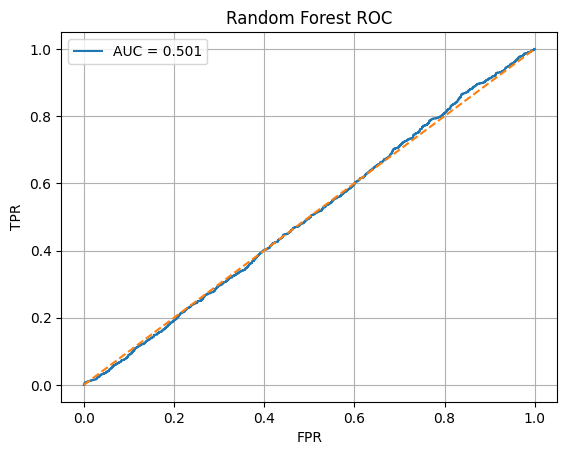

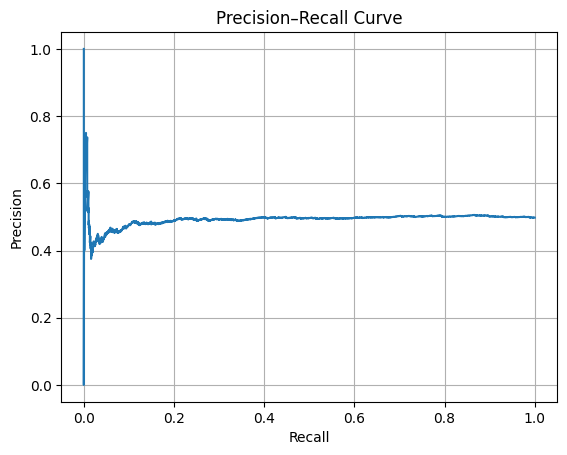

In [13]:
y_proba = best_rf.predict_proba(X_test)[:, 1]

#ROC curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1],[0,1],'--')
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("Random Forest ROC"); plt.legend(); plt.grid(True)
plt.show()

#PR curve
prec, rec, _ = precision_recall_curve(y_test, y_proba)
plt.figure()
plt.plot(rec, prec)
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("Precision–Recall Curve"); plt.grid(True)
plt.show()


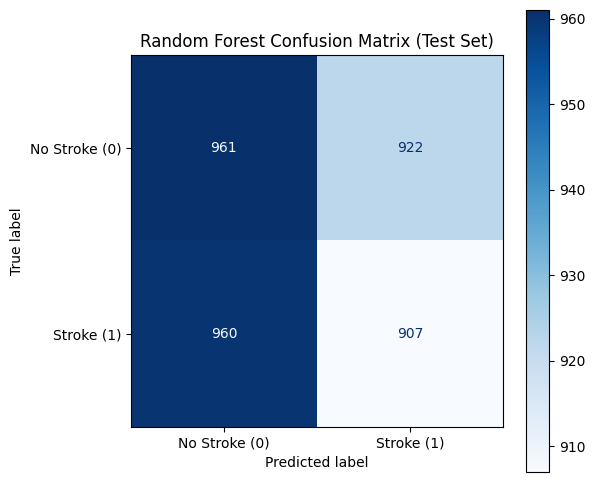

In [14]:
#Plot Confusion Matrix
cm = confusion_matrix(y_test, y_pred_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Stroke (0)', 'Stroke (1)'])
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(cmap=plt.cm.Blues, values_format='d', ax=ax)
plt.title("Random Forest Confusion Matrix (Test Set)")
plt.show()

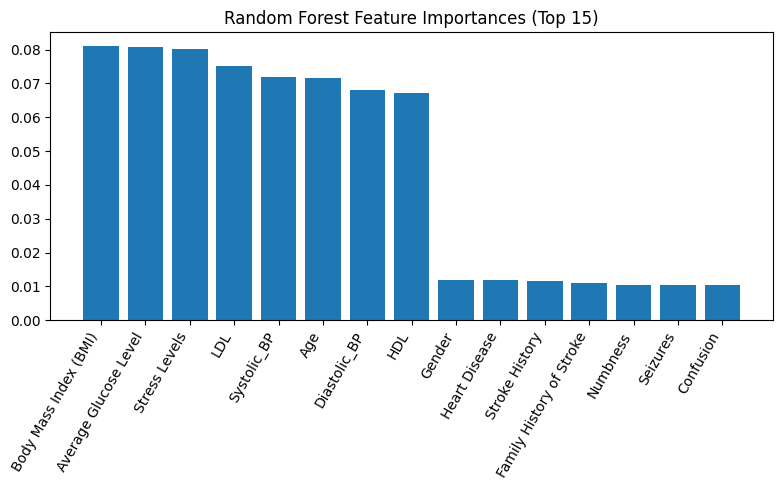

In [16]:
#Plotting importance of features
importances = best_rf.feature_importances_
idx = np.argsort(importances)[::-1][:15]
names = np.array(X_train.columns)[idx]
plt.figure(figsize=(8,5))
plt.bar(range(len(idx)), importances[idx])
plt.xticks(range(len(idx)), names, rotation=60, ha="right")
plt.title("Random Forest Feature Importances (Top 15)")
plt.tight_layout();
plt.show()
